In [3]:
cd /research/cbim/medical/lh599/active/SimCLR/cifar10

/research/cbim/medical/lh599/active/SimCLR


In [10]:
import os
import random
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
# from data_aug.contrastive_learning_dataset import ContrastiveLearningDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# dataset = ContrastiveLearningDataset('data')
# train_dataset = dataset.get_dataset2('cifar10', 2)
# train_loader = torch.utils.data.DataLoader(
#         train_dataset, batch_size=256, shuffle=True,
#         num_workers=0, pin_memory=False, drop_last=True)

Files already downloaded and verified


In [7]:
class Config(object):
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)


In [32]:
# ESSL
import torchvision.transforms as T
from main import ContrastiveLearningTransform2, Branch
# from main2 import ContrastiveLearningTransform, Branch

device = 'cuda'

normalize = T.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
single_transform = T.Compose([T.ToTensor(), normalize])

args = Config(dim_proj='2048,2048', dim_pred=512, loss='simclr')

model = Branch(args).to(device)
saved_dict = torch.load('simclr-cifar10-resnet18-800ep-1.pth')['state_dict']
model.load_state_dict(saved_dict, strict=True)

<All keys matched successfully>

In [33]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.CIFAR10(
        '../data', train=True, transform=ContrastiveLearningTransform2(), download=True
    ),
    shuffle=True,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=0,
    drop_last=True
)


Files already downloaded and verified


In [12]:
def image2tensor(image):
    image = torch.FloatTensor(image).permute(2,0,1).unsqueeze(0)/255.
    return (image-0.5)/0.5

def tensor2image(tensor):
    tensor = tensor.clamp_(-1., 1.).detach().squeeze().permute(1,2,0).cpu().numpy()
    return tensor*0.5 + 0.5

def imshow(img, size=5, cmap='jet'):
    plt.figure(figsize=(size,size))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

label2class = {0: 'airplanes', 1: 'cars', 2: 'birds', 3: 'cats', 4: 'deer', \
               5: 'dogs', 6: 'frogs', 7: 'horses', 8: 'ships', 9: 'trucks'}

def sample_data(loader):
    while True:
        for batch in loader:
            yield batch

In [34]:
# loader = iter(train_loader)
loader = sample_data(train_loader)
imgs, _ = next(loader)

In [35]:
len(imgs)

4

In [36]:
[label2class[l.item()] for l in _[:16]]

['cats',
 'deer',
 'birds',
 'airplanes',
 'deer',
 'cats',
 'cars',
 'deer',
 'frogs',
 'cars',
 'birds',
 'birds',
 'birds',
 'horses',
 'trucks',
 'horses']

orig | view1 | view2


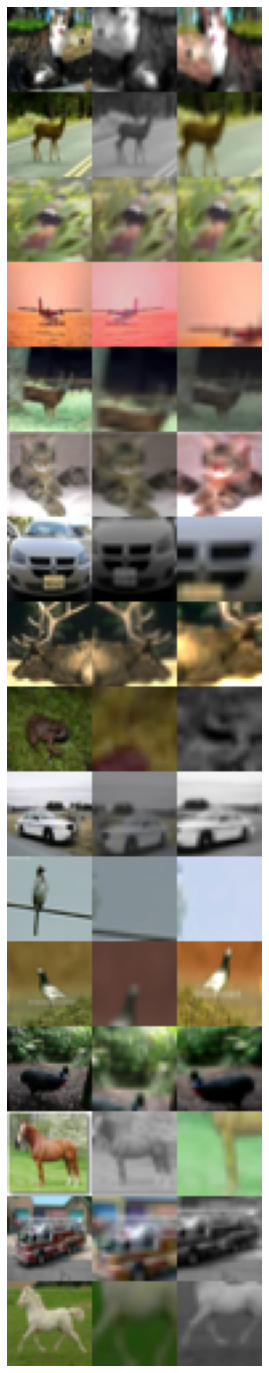

In [37]:
# inverse_normalize = lambda x: x * 2 -1
# n = 16
# imgs_orig  = torch.cat([img for img in imgs[0][:n,...]], dim=1)
# imgs_view1 = torch.cat([img for img in imgs[1][:n,...]], dim=1)
# imgs_view2 = torch.cat([img for img in imgs[2][:n,...]], dim=1)
# print('orig | view1 | view2')
# imshow(tensor2image(torch.cat([imgs_orig*2-1, imgs_view1*2-1, imgs_view2*2-1], dim=2)),25)

inverse_normalize = T.Compose(
    [
        T.Normalize([-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010], [1/0.2023, 1/0.1994, 1/0.2010]),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)
n = 16
imgs_orig  = torch.cat([img for img in imgs[0][:n,...]], dim=1)
imgs_view1 = torch.cat([img for img in imgs[1][:n,...]], dim=1)
imgs_view2 = torch.cat([img for img in imgs[2][:n,...]], dim=1)
print('orig | view1 | view2')
imshow(tensor2image(torch.cat(
    [
        inverse_normalize(imgs_orig),
        inverse_normalize(imgs_view1),
        inverse_normalize(imgs_view2),
    ], dim=2)),25)

In [15]:
# class ResNetSimCLR(nn.Module):

#     def __init__(self, base_model, out_dim):
#         super(ResNetSimCLR, self).__init__()

#         self.backbone = torchvision.models.resnet18(pretrained=False, num_classes=out_dim)
#         dim_mlp = self.backbone.fc.in_features

#         # add mlp projection head
#         self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)

#     def forward(self, x):
#         return self.backbone(x)

# # SimCLR encoder with projection head
# device = 'cuda'
# model = ResNetSimCLR('resnet18', 128).to(device)
# checkpoint = torch.load('../stylegan2-encoder-pytorch/checkpoint/simclr/cifar10/checkpoint_0100.pth.tar', map_location=device)
# state_dict = checkpoint['state_dict']
# model.load_state_dict(state_dict, strict=True)


<All keys matched successfully>

In [26]:
h0 = model(imgs[0].cuda())
h1 = model(imgs[1].cuda())

In [30]:
len(imgs)

4

In [28]:
imgs_view1.min()

tensor(-2.4291)

In [38]:
from functools import partial
from tqdm import tqdm
import pdb
st = pdb.set_trace

# normalize = lambda x: x
normalize = partial(F.normalize, dim=1)
p = 2
n_views = 3
batch_size = 256

d01_list = list()
d02_list = list()
d12_list = list()

s01_list = list()
s02_list = list()
s12_list = list()

s_pos = list()
s_neg = list()
d_pos = list()
d_neg = list()

with torch.no_grad():
    for i in tqdm(range(100)):
        imgs, _ = next(loader)
        h0 = model(imgs[0].cuda())
        h1 = model(imgs[1].cuda())
        h2 = model(imgs[2].cuda())
        h0 = normalize(h0)
        h1 = normalize(h1)
        h2 = normalize(h2)
        
        d01 = torch.norm(h0 - h1, p=p, dim=1)
        d02 = torch.norm(h0 - h2, p=p, dim=1)
        d12 = torch.norm(h1 - h2, p=p, dim=1)
        s01 = torch.sum(h0 * h1, dim=1)
        s02 = torch.sum(h0 * h2, dim=1)
        s12 = torch.sum(h1 * h2, dim=1)
        
        d01_list.append(d01)
        d02_list.append(d02)
        d12_list.append(d12)
        s01_list.append(s01)
        s02_list.append(s02)
        s12_list.append(s12)
        
        features = torch.cat([h0, h1, h2], dim=0)
        similarity_matrix = torch.matmul(features, features.T)
        distance_matrix = torch.cdist(features, features, p=p)
        
        labels = torch.cat([torch.arange(batch_size) for i in range(n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        mask = torch.eye(labels.shape[0], dtype=torch.bool)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        distance_matrix = distance_matrix[~mask].view(similarity_matrix.shape[0], -1)
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)
        s_pos.append(positives)
        s_neg.append(negatives)
        
        dist_pos = distance_matrix[labels.bool()].view(labels.shape[0], -1)
        dist_neg = distance_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)
        d_pos.append(dist_pos)
        d_neg.append(dist_neg)

d01 = torch.cat(d01_list, dim=0)
d02 = torch.cat(d02_list, dim=0)
d12 = torch.cat(d12_list, dim=0)
s01 = torch.cat(s01_list, dim=0)
s02 = torch.cat(s02_list, dim=0)
s12 = torch.cat(s12_list, dim=0)
s_pos = torch.cat(s_pos, dim=0)
s_neg = torch.cat(s_neg, dim=0)
d_pos = torch.cat(d_pos, dim=0)
d_neg = torch.cat(d_neg, dim=0)
print(f"distance: (0, 1): {d01.mean().item():.4f}, (0, 2): {d02.mean().item():.4f}, (1, 2): {d12.mean().item():.4f}")
print(f"cosine: (0, 1): {s01.mean().item():.4f}, (0, 2): {s02.mean().item():.4f}, (1, 2): {s12.mean().item():.4f}")
print(f"cosine: positive: {s_pos.mean().item():.4f}, negative: {s_neg.mean().item():.4f}")
print(f"distance: positive: {d_pos.mean().item():.4f}, negative: {d_neg.mean().item():.4f}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]

distance: (0, 1): 0.2831, (0, 2): 0.2808, (1, 2): 0.2274
cosine: (0, 1): 0.9441, (0, 2): 0.9453, (1, 2): 0.9558
cosine: positive: 0.9484, negative: -0.0034
distance: positive: 0.2638, negative: 1.4122


In [ ]:
# Steering
# start from z0 to reconstruct x1
device = 'cuda'
image_size = 32

g_model_path = '../stylegan2-encoder-pytorch/checkpoint/c10.pt'
g_ckpt = torch.load(g_model_path, map_location=device)

latent_dim = g_ckpt['args'].latent

generator = Generator(image_size, latent_dim, 8).to(device)
generator.load_state_dict(g_ckpt["g_ema"], strict=False)
generator.eval()
print('[generator loaded]')

e_model_path = '../stylegan2-encoder-pytorch/checkpoint_c10/encoder_900000.pt'
e_ckpt = torch.load(e_model_path, map_location=device)

encoder = Encoder(image_size, latent_dim).to(device)
encoder.load_state_dict(e_ckpt['e'])
encoder.eval()
print('[encoder loaded]')

truncation = 0.7
trunc = generator.mean_latent(4096).detach().clone()

